In [1]:
import matplotlib.pyplot as plt
from botorch.models.transforms import Standardize

from hysteresis.base import TorchHysteresis
from torchAccelerator.hysteresis import HysteresisAccelerator, HysteresisQuad
from torchAccelerator.first_order import TorchDrift
import torch
from copy import deepcopy

from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model
from botorch.utils import standardize
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import UpperConfidenceBound
from botorch.optim import optimize_acqf


def density_function(mesh_pts):
    x = mesh_pts[:, 0]
    y = mesh_pts[:, 1]
    return torch.exp(-(y - x) / 0.5)


def beamsize(accel_model, R_i):
    return accel_model.forward(R_i)[0, 0]

def get_iterative_min(loss):
    result = torch.empty(len(loss))
    for i in range(1, len(loss)):
        result[i] = torch.min(loss[:i])
    return result

def total_beamsize(R):
    return torch.sqrt(R[0, 0] + R[2, 2])

q1.fantasy_H:Parameter containing:
tensor([-1.], requires_grad=True)
q2.fantasy_H:Parameter containing:
tensor([-1.], requires_grad=True)
q3.fantasy_H:Parameter containing:
tensor([-1.], requires_grad=True)
applying field tensor([-0., -0., -0.])
applying field tensor([-0.9868,  1.0000,  1.0000])
applying field tensor([ 0.2194, -0.3410, -0.2152])
applying field tensor([-0.0019, -0.0438, -0.4495])
applying field tensor([ 0.3651,  0.0649, -0.2591])
applying field tensor([ 0.3882, -0.2355, -0.6300])
applying field tensor([ 0.4780, -0.1838,  0.1790])
applying field tensor([ 0.7864, -0.3131, -0.2203])
applying field tensor([ 0.0321, -0.4327,  0.3530])
applying field tensor([-0.4061, -0.4524, -0.1749])
applying field tensor([ 0.2629, -0.8257,  0.1355])
applying field tensor([ 0.5954, -0.6473,  0.7352])
applying field tensor([ 0.0142, -0.8559, -0.5589])
applying field tensor([-2.6915e-01, -1.0000e+00, -8.1961e-05])
applying field tensor([-0.2420, -0.4677, -1.0000])
applying field tensor([ 0.50

C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values det

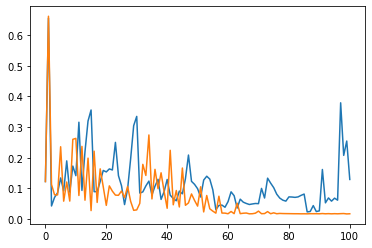

In [2]:
def optimize(accelerator_model, initial_beam_matrix, apply_fields=False):

    iterations = 100
    train_X = torch.ones((1, 3)) * -0.0
    accelerator_model.q1.fantasy_H.data = train_X[0][0]
    accelerator_model.q2.fantasy_H.data = train_X[0][1]
    accelerator_model.q3.fantasy_H.data = train_X[0][2]

    train_Y = total_beamsize(
        accelerator_model.forward(initial_beam_matrix)
    ).reshape(1, 1)

    if apply_fields:
        print(f"applying field {train_X[-1]}")
        accelerator_model.apply_fields({"q1": train_X[-1][0],
                                        "q2": train_X[-1][1],
                                        "q3": train_X[-1][2]})

    for i in range(iterations):
        std_trans = Standardize(1)
        gp = SingleTaskGP(train_X, train_Y.detach(), outcome_transform=std_trans)
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
        fit_gpytorch_model(mll)

        UCB = UpperConfidenceBound(gp, beta=2.0, maximize=False)

        bounds = torch.stack([-1.0 * torch.ones(3), torch.ones(3)])
        candidate, acq_value = optimize_acqf(
            UCB,
            bounds=bounds,
            q=1,
            num_restarts=5,
            raw_samples=20,
        )
        train_X = torch.cat((train_X, candidate))
        accelerator_model.q1.fantasy_H.data = candidate[0][0]
        accelerator_model.q2.fantasy_H.data = candidate[0][1]
        accelerator_model.q3.fantasy_H.data = candidate[0][2]

        # make next measurement
        bs = total_beamsize(
            accelerator_model.forward(initial_beam_matrix)
        ).reshape(1, 1)
        train_Y = torch.cat((train_Y, bs))

        if apply_fields:
            print(f"applying field {train_X[-1]}")
            accelerator_model.apply_fields({"q1": train_X[-1][0],
                                            "q2": train_X[-1][1],
                                            "q3": train_X[-1][2]})

    return train_X, train_Y, accelerator_model


# hysteresis model
H = TorchHysteresis(mesh_scale=0.1, trainable=False)
dens = density_function(H.mesh_points)
H.h_min = -1.0
H.hysterion_density = dens

# define quadrupoles
d0 = TorchDrift("d0", torch.tensor(1.0))
q1 = HysteresisQuad("q1", torch.tensor(0.1), deepcopy(H), scale=torch.tensor(100.0))
d1 = TorchDrift("d1", torch.tensor(1.0))
d2 = TorchDrift("d2", torch.tensor(1.0))
q2 = HysteresisQuad("q2", torch.tensor(0.1), deepcopy(H), scale=torch.tensor(100.0))
d3 = TorchDrift("d3", torch.tensor(0.5))
q3 = HysteresisQuad("q3", torch.tensor(0.1), deepcopy(H), scale=torch.tensor(100.0))

HA = HysteresisAccelerator([d0, q1, d1, q2, d2, q3, d3])

for name, val in HA.named_parameters():
    if val.requires_grad:
        print(f"{name}:{val}")

init_beam_matrix = torch.eye(6) * 1.0e-8

#set x_rms beam size to 1 mm and rms divergence to 0.1 mrad
init_beam_matrix[0,0] = 1.0e-3 ** 2
init_beam_matrix[1,1] = 1.0e-4 ** 2
init_beam_matrix[2,2] = 1.0e-3 ** 2
init_beam_matrix[3,3] = 1.0e-4 ** 2
R = init_beam_matrix
fig2, ax2 = plt.subplots()

# plot beam size as a function of fantasy_H
h_f = torch.linspace(-1.0, 1, 100)

points = []
sizes = []
models = []
for ele, c in zip([True, False], ["C0", "C1"]):
    p, l, model = optimize(deepcopy(HA), R, ele)
    points += [p.clone()]
    sizes += [l.clone()]
    models += [model]
    size = torch.sqrt(l.squeeze()).detach()
    ax2.plot(size, c=c)


tensor([-0.1405,  0.2207, -0.1389])
tensor([0.0236], grad_fn=<SqrtBackward>)
tensor(0.0167, grad_fn=<SqrtBackward>)


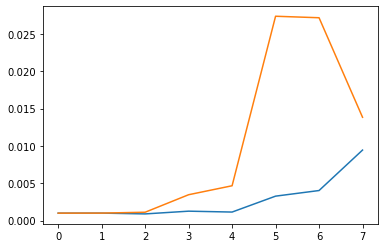

In [3]:
min_pt = points[0][torch.argmin(sizes[0])]
min_val = sizes[0][torch.argmin(sizes[0])]
#model.q1.fantasy_H.data = min_pt[0]
#model.q2.fantasy_H.data = min_pt[1]
#model.q3.fantasy_H.data = min_pt[2]

print(min_pt)
print(torch.sqrt(min_val))
R_f = models[0].forward(R, full=False, current=True)
print(torch.sqrt(R_f[-1, 0, 0] + R_f[-1, 2, 2]))
#plot beamsize
plt.plot(torch.sqrt(R_f)[:,0,0].detach())
plt.plot(torch.sqrt(R_f)[:,2,2].detach())